In [2]:
# import pandas as pd
# import re
# import os
#
# def csi_txt_to_excel(txt_path, out_dir=None, expand_data=False, max_data_cols=0):
#     """
#     Convert concatenated CSI text into an Excel .xlsx file.
#
#     Parameters
#     ----------
#     txt_path : str
#         Path to the input .txt file.
#     out_dir : str or None
#         Writable directory for the output .xlsx. If None, the function auto-selects:
#         - same directory as txt_path if writable
#         - '/kaggle/working' if available and writable
#         - current working directory otherwise
#     expand_data : bool
#         If True, expand the values inside data=[...] into separate columns (Data0, Data1, ...).
#         If False, keep the full list as a single string in column 'Data'.
#     max_data_cols : int
#         Max number of data columns to create when expand_data=True.
#         0 means auto-cap to Excel's column limit (up to 16,384 minus metadata columns).
#
#     Returns
#     -------
#     str
#         Absolute path to the saved .xlsx file.
#     """
#
#     # Read the entire file
#     with open(txt_path, "r", encoding="utf-8") as f:
#         content = f.read()
#
#     # Normalize escaped newlines in case the file is one long line like "...]\nCSI_DATA..."
#     content = content.replace("\\n", "\n")
#
#     # Split into records; keep 'CSI_DATA,' at the start of each chunk
#     chunks = re.split(r'(?=CSI_DATA,)', content)
#     rows = []
#
#     for rec in chunks:
#         rec = rec.strip()
#         if not rec.startswith("CSI_DATA,"):
#             continue
#
#         # Extract MAC: token right after "CSI_DATA,"
#         m_mac = re.search(r'^CSI_DATA,([^,]+)', rec)
#         mac = m_mac.group(1).strip() if m_mac else ""
#
#         # Extract timestamp after "Now="
#         m_time = re.search(r'Now=\s*([0-9\-]{10}\s[0-9:\.]{8,})', rec)
#         timestamp = m_time.group(1).strip() if m_time else ""
#
#         # Extract data list inside brackets
#         m_data = re.search(r'data=\[([^\]]*)\]', rec)
#         data_str = m_data.group(1).strip() if m_data else ""
#         data_list = [s.strip() for s in data_str.split(",")] if data_str else []
#
#         row = {"MAC": mac, "Timestamp": timestamp, "Data": data_str}
#
#         if expand_data:
#             # Determine max columns we can safely create for Excel
#             if max_data_cols <= 0:
#                 # Excel limit is 16,384 columns; we already have 3 meta columns
#                 max_cols_possible = 16384 - 3
#             else:
#                 max_cols_possible = max_data_cols
#
#             for i, val in enumerate(data_list[:max_cols_possible]):
#                 row[f"Data{i}"] = val
#
#             # Inform if truncated
#             if len(data_list) > max_cols_possible:
#                 row["Data_Truncated"] = f"{len(data_list) - max_cols_possible} values truncated"
#
#         rows.append(row)
#
#     # Build DataFrame
#     df = pd.DataFrame(rows)
#
#     # Helper to test if a directory is writable
#     def is_writable(dirpath: str) -> bool:
#         try:
#             test_path = os.path.join(dirpath, ".write_test")
#             with open(test_path, "w") as tmp:
#                 tmp.write("ok")
#             os.remove(test_path)
#             return True
#         except Exception:
#             return False
#
#     # Decide output directory
#     src_dir = os.path.dirname(os.path.abspath(txt_path))
#     if out_dir:
#         os.makedirs(out_dir, exist_ok=True)
#         target_dir = out_dir
#     elif is_writable(src_dir):
#         target_dir = src_dir
#     elif os.path.isdir("/kaggle/working") and is_writable("/kaggle/working"):
#         target_dir = "/kaggle/working"
#     else:
#         target_dir = os.getcwd()
#
#     # Build output path
#     base_name = os.path.splitext(os.path.basename(txt_path))[0]
#     excel_path = os.path.join(target_dir, base_name + ".xlsx")
#
#     # Save to Excel
#     df.to_excel(excel_path, index=False)
#
#     return os.path.abspath(excel_path)
#
#
# # Example usage (auto-saves to /kaggle/working since /kaggle/input is read-only):
# paths = ['csi1/15-41-51-299.txt']
# for i in paths:
#     out_path = csi_txt_to_excel(i)
#
#


In [3]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import zscore
# import os
#
# paths = ['csi1/15-41-51-299']
# for inumber,i in enumerate(paths):
#     file_path = f"{i}.xlsx"
#     df = pd.read_excel(file_path)
#
#     print("Shape:", df.shape)
#     print(df.head())
#
#     # ===== 2. پردازش ستون Data =====
#     # جدا کردن رشته به لیست اعداد
#     df["Data_list"] = df["Data"].apply(lambda x: np.array([int(i) for i in str(x).split(",") if i.strip() != ""]))
#
#     # پیدا کردن طول بیشینه
#     max_len = df["Data_list"].apply(len).max()
#
#     # نرمال کردن طول آرایه‌ها (padding با NaN)
#     data_matrix = np.array([
#         np.pad(arr.astype(float), (0, max_len - len(arr)), constant_values=np.nan)
#         for arr in df["Data_list"]
#     ])
#
#     # ساخت دیتافریم عددی
#     df_expanded = pd.DataFrame(data_matrix)
#
#     print("\nExpanded shape:", df_expanded.shape)
#
#     # ===== 3. محاسبات آماری =====
#     stats = df_expanded.describe().T
#     stats["variance"] = df_expanded.var(skipna=True)
#     print("\n=== Statistical Summary (first 10 features) ===\n", stats.head(10))
#
#     # ===== 4. شناسایی Outliers =====
#     z_scores = np.abs(zscore(df_expanded, nan_policy='omit'))
#     outliers = (z_scores > 3).sum(axis=0)
#     print("\nNumber of outliers in each feature (first 10 cols):\n", outliers[:10])
#
#     # ===== 5. ترسیم نمودار برای هر کانال (با 3 ساب‌پلات) =====
#     output_dir = "plots_all_channels"
#     os.makedirs(output_dir, exist_ok=True)
#
#     for col in df_expanded.columns:
#         channel_data = df_expanded[col].dropna()
#
#         fig, axes = plt.subplots(1, 3, figsize=(18, 4))
#
#         # --- Histogram ---
#         axes[0].hist(channel_data, bins=30, color="skyblue", edgecolor="black")
#         axes[0].set_title(f"Histogram - Channel {col}")
#         axes[0].set_xlabel("Value")
#         axes[0].set_ylabel("Frequency")
#
#         # --- Boxplot ---
#         sns.boxplot(x=channel_data, ax=axes[1], color="lightcoral")
#         axes[1].set_title(f"Boxplot - Channel {col}")
#         axes[1].set_xlabel("Value")
#
#         # --- Line plot ---
#         axes[2].plot(channel_data, color="navy")
#         axes[2].set_title(f"Time Series - Channel {col}")
#         axes[2].set_xlabel("Index")
#         axes[2].set_ylabel("Value")
#
#         plt.suptitle(f"Channel {col} - Data Analysis", fontsize=14)
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         plt.savefig(os.path.join(output_dir, f"channel_{col}_{inumber}_analysis.png"))
#         print(inumber)
#         plt.close()
#
#     print(f"\n✅ All combined plots saved in folder: {output_dir}")


In [4]:
import pandas as pd
import re
import os
from tqdm import tqdm

def csi_txt_to_excel(txt_path, out_dir=None, expand_data=False, max_data_cols=0):
    """
    Convert concatenated CSI text into an Excel .xlsx file.

    Parameters
    ----------
    txt_path : str
        Path to the input .txt file.
    out_dir : str or None
        Writable directory for the output .xlsx. If None, the function auto-selects:
        - same directory as txt_path if writable
        - '/kaggle/working' if available and writable
        - current working directory otherwise
    expand_data : bool
        If True, expand the values inside data=[...] into separate columns (Data0, Data1, ...).
        If False, keep the full list as a single string in column 'Data'.
    max_data_cols : int
        Max number of data columns to create when expand_data=True.
        0 means auto-cap to Excel's column limit (up to 16,384 minus metadata columns).

    Returns
    -------
    str
        Absolute path to the saved .xlsx file.
    """

    # Read the entire file
    with open(txt_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Normalize escaped newlines in case the file is one long line like "...]\nCSI_DATA..."
    content = content.replace("\\n", "\n")

    # Split into records; keep 'CSI_DATA,' at the start of each chunk
    chunks = re.split(r'(?=CSI_DATA,)', content)
    rows = []

    for rec in chunks:
        rec = rec.strip()
        if not rec.startswith("CSI_DATA,"):
            continue

        # Extract MAC: token right after "CSI_DATA,"
        m_mac = re.search(r'^CSI_DATA,([^,]+)', rec)
        mac = m_mac.group(1).strip() if m_mac else ""

        # Extract timestamp after "Now="
        m_time = re.search(r'Now=\s*([0-9\-]{10}\s[0-9:\.]{8,})', rec)
        timestamp = m_time.group(1).strip() if m_time else ""

        # Extract data list inside brackets
        m_data = re.search(r'data=\[([^\]]*)\]', rec)
        data_str = m_data.group(1).strip() if m_data else ""
        data_list = [s.strip() for s in data_str.split(",")] if data_str else []

        row = {"MAC": mac, "Timestamp": timestamp, "Data": data_str}

        if expand_data:
            # Determine max columns we can safely create for Excel
            if max_data_cols <= 0:
                # Excel limit is 16,384 columns; we already have 3 meta columns
                max_cols_possible = 16384 - 3
            else:
                max_cols_possible = max_data_cols

            for i, val in enumerate(data_list[:max_cols_possible]):
                row[f"Data{i}"] = val

            # Inform if truncated
            if len(data_list) > max_cols_possible:
                row["Data_Truncated"] = f"{len(data_list) - max_cols_possible} values truncated"

        rows.append(row)

    # Build DataFrame
    df = pd.DataFrame(rows)

    # Helper to test if a directory is writable
    def is_writable(dirpath: str) -> bool:
        try:
            test_path = os.path.join(dirpath, ".write_test")
            with open(test_path, "w") as tmp:
                tmp.write("ok")
            os.remove(test_path)
            return True
        except Exception:
            return False

    # Decide output directory
    src_dir = os.path.dirname(os.path.abspath(txt_path))
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        target_dir = out_dir
    elif is_writable(src_dir):
        target_dir = src_dir
    elif os.path.isdir("/kaggle/working") and is_writable("/kaggle/working"):
        target_dir = "/kaggle/working"
    else:
        target_dir = os.getcwd()

    # Build output path
    base_name = os.path.splitext(os.path.basename(txt_path))[0]
    excel_path = os.path.join(target_dir, 'xl')
    excel_path = os.path.join(excel_path, base_name + ".xlsx")

    # Save to Excel
    df.to_excel(excel_path, index=False)
    return os.path.abspath(excel_path)

def convert_all_txt_in_folders(root_folders, expand_data=False, max_data_cols=0):
    """
    Convert all .txt files inside given folders to .xlsx files using csi_txt_to_excel,
    saving each Excel file in the same folder as the original .txt file.

    Parameters
    ----------
    root_folders : list of str
        List of folder paths containing .txt files to convert.
    expand_data : bool
        Passed to csi_txt_to_excel to control data expansion.
    max_data_cols : int
        Passed to csi_txt_to_excel for max data columns if expand_data=True.
    """
    for folder in tqdm(root_folders):
        for dirpath, _, filenames in os.walk(folder):
            for filename in filenames:
                if filename.lower().endswith('.txt'):
                    txt_path = os.path.join(dirpath, filename)
                    # print(f"Converting: {txt_path}")
                    out_path = csi_txt_to_excel(txt_path, out_dir=dirpath,
                                                expand_data=expand_data,
                                                max_data_cols=max_data_cols)
                    # print(f"✅ Saved to: {out_path}")

folders = [
    r"D:\Mojtaba\Dataset_Master_minds\DataSet_test\csi1",
    r"D:\Mojtaba\Dataset_Master_minds\DataSet_test\csi2",
    r"D:\Mojtaba\Dataset_Master_minds\DataSet_test\csi3",
    r"D:\Mojtaba\Dataset_Master_minds\DataSet_test\csi4"
]

convert_all_txt_in_folders(folders)

100%|██████████| 4/4 [00:00<00:00, 6850.64it/s]


---
plots
---
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os
from tqdm import tqdm

folders = [
    r"DataSet_test\csi1\xl",
    r"DataSet_test\csi2\xl",
    r"DataSet_test\csi3\xl",
    r"DataSet_test\csi4\xl"
]

for folder in tqdm(folders, desc="Folders", unit="folder"):
    # پیدا کردن همه فایل‌های xlsx داخل این فولدر (و زیر‌فولدرها)
    xlsx_paths = []
    for dirpath, _, filenames in os.walk(folder):
        for fn in filenames:
            if fn.lower().endswith('.xlsx'):
                xlsx_paths.append(os.path.join(dirpath, fn))

    if len(xlsx_paths) == 0:
        tqdm.write(f"No .xlsx files found in: {folder}")
        continue

    # فقط 1 نمونه (فایل) از هر پوشه بردار
    xlsx_paths = xlsx_paths[:1]

    # نوار پیشرفت برای فایل‌های انتخاب‌شده
    for file_idx, xlsx_path in enumerate(tqdm(xlsx_paths, desc=f"Files in {os.path.basename(folder)}", leave=False, unit="file")):
        filename = os.path.basename(xlsx_path)
        dirpath = os.path.dirname(xlsx_path)

        df = pd.read_excel(xlsx_path)

        # ===== 2. پردازش ستون Data =====
        df["Data_list"] = df["Data"].apply(lambda x: np.array([int(i) for i in str(x).split(",") if i.strip() != ""]))

        max_len = df["Data_list"].apply(len).max()

        data_matrix = np.array([
            np.pad(arr.astype(float), (0, max_len - len(arr)), constant_values=np.nan)
            for arr in df["Data_list"]
        ])

        df_expanded = pd.DataFrame(data_matrix)

        # ===== 3. محاسبات آماری =====
        stats = df_expanded.describe().T
        stats["variance"] = df_expanded.var(skipna=True)

        # ===== 4. شناسایی Outliers =====
        z_scores = np.abs(zscore(df_expanded, nan_policy='omit'))
        outliers = (z_scores > 3).sum(axis=0)

        # ===== 5. ترسیم نمودار =====
        output_dir = os.path.join(dirpath, 'plots')
        os.makedirs(output_dir, exist_ok=True)

        # تعداد جفت کانال = ceil(total_channels / 2)
        n_pairs = (df_expanded.shape[1] + 1) // 2

        # tqdm برای هر جفت کانال — با total قابل نمایش ETA
        for pair_num in tqdm(range(n_pairs),
                             desc=f"File {file_idx+1}/{len(xlsx_paths)}: {filename}",
                             leave=False,
                             unit="pair"):
            i = pair_num * 2  # کانال real شروع
            fig, axes = plt.subplots(2, 3, figsize=(18, 8))

            for j in range(2):  # 0 = real, 1 = imag
                col = i + j
                if col >= df_expanded.shape[1]:
                    # اگر تعداد کانال‌ها فرد بود ممکنه اینجا از حدود بیرون بزنه؛ ادامه بده
                    for empty_ax in axes[j]:
                        empty_ax.axis('off')
                    continue

                channel_data = df_expanded[col].dropna()

                # اگر داده‌ای نبود، محتوای خالی بذار
                if channel_data.size == 0:
                    for ax in axes[j]:
                        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
                        ax.set_axis_off()
                    continue

                mean_val = stats.loc[col, "mean"]
                var_val = stats.loc[col, "variance"]

                # --- Histogram ---
                axes[j, 0].hist(channel_data, bins=30, edgecolor="black")
                axes[j, 0].axvline(mean_val, color="red", linestyle="--", label=f"Mean={mean_val:.2f}")
                axes[j, 0].legend()
                axes[j, 0].set_title(f"Histogram - Channel {col}\nVariance={var_val:.2f}")
                axes[j, 0].set_xlabel("Value")
                axes[j, 0].set_ylabel("Frequency")

                # --- Boxplot ---
                sns.boxplot(x=channel_data, ax=axes[j, 1])
                # اگر outliers[col] NaN بود، نمایش نده
                try:
                    out_count = int(outliers[col])
                except Exception:
                    out_count = 0
                axes[j, 1].set_title(f"Boxplot - Channel {col}\nOutliers={out_count}")
                axes[j, 1].set_xlabel("Value")

                # --- Line plot ---
                axes[j, 2].plot(channel_data)
                axes[j, 2].set_title(f"Time Series - Channel {col}")
                axes[j, 2].set_xlabel("Index")
                axes[j, 2].set_ylabel("Value")
                axes[j, 2].text(0.01, 0.95,
                                f"Mean={mean_val:.2f}\nMin={channel_data.min():.2f}\nMax={channel_data.max():.2f}",
                                transform=axes[j, 2].transAxes,
                                fontsize=9, verticalalignment='top',
                                bbox=dict(facecolor='white', alpha=0.6))

            plt.suptitle(f"Channels {i} (Real) & {i+1} (Imag) - Data Analysis", fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            out_fname = os.path.join(output_dir, f"channels_{i}_{i+1}_analysis.png")
            plt.savefig(out_fname)
            plt.close()


Files in xl:   0%|          | 0/1 [00:00<?, ?file/s]

File 1/1: 15-41-51-299.xlsx:   0%|          | 0/64 [00:00<?, ?pair/s]

File 1/1: 15-41-51-299.xlsx:   2%|▏         | 1/64 [00:01<01:08,  1.09s/pair]

File 1/1: 15-41-51-299.xlsx:   3%|▎         | 2/64 [00:02<01:08,  1.11s/pair]

File 1/1: 15-41-51-299.xlsx:   5%|▍         | 3/64 [00:03<01:03,  1.04s/pair]

File 1/1: 15-41-51-299.xlsx:   6%|▋         | 4/64 [00:04<01:04,  1.07s/pair]

File 1/1: 15-41-51-299.xlsx:   8%|▊         | 5/64 [00:05<00:59,  1.00s/pair]

File 1/1: 15-41-51-299.xlsx:   9%|▉         | 6/64 [00:06<01:00,  1.05s/pair]

File 1/1: 15-41-51-299.xlsx:  11%|█         | 7/64 [00:07<00:54,  1.05pair/s]

File 1/1: 15-41-51-299.xlsx:  12%|█▎        | 8/64 [00:07<00:50,  1.12pair/s]

File 1/1: 15-41-51-299.xlsx:  14%|█▍        | 9/64 [00:08<00:46,  1.18pair/s]

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os
from tqdm import tqdm

folders = [
    r"DataSet_test\csi1\xl",
    r"DataSet_test\csi2\xl",
    r"DataSet_test\csi3\xl",
    r"DataSet_test\csi4\xl"
]

for folder in tqdm(folders, desc="Folders", unit="folder"):
    xlsx_paths = []
    for dirpath, _, filenames in os.walk(folder):
        for fn in filenames:
            if fn.lower().endswith('.xlsx'):
                xlsx_paths.append(os.path.join(dirpath, fn))

    if len(xlsx_paths) == 0:
        tqdm.write(f"No .xlsx files found in: {folder}")
        continue

    xlsx_paths = xlsx_paths[:1]   # فقط یک فایل نمونه از هر پوشه

    for file_idx, xlsx_path in enumerate(tqdm(xlsx_paths,
                                              desc=f"Files in {os.path.basename(folder)}",
                                              leave=False, unit="file")):
        filename = os.path.basename(xlsx_path)
        dirpath = os.path.dirname(xlsx_path)

        df = pd.read_excel(xlsx_path)

        # ===== 2. پردازش ستون Data =====
        df["Data_list"] = df["Data"].apply(lambda x: np.array([int(i) for i in str(x).split(",") if i.strip() != ""]))

        max_len = df["Data_list"].apply(len).max()

        data_matrix = np.array([
            np.pad(arr.astype(float), (0, max_len - len(arr)), constant_values=np.nan)
            for arr in df["Data_list"]
        ])

        df_expanded = pd.DataFrame(data_matrix)

        # ===== 3. محاسبات آماری =====
        stats = df_expanded.describe().T
        stats["variance"] = df_expanded.var(skipna=True)

        # ===== 4. شناسایی Outliers =====
        z_scores = np.abs(zscore(df_expanded, nan_policy='omit'))
        outliers = (z_scores > 3).sum(axis=0)

        # ===== 5. ترسیم نمودار =====
        output_dir = os.path.join(dirpath, 'plots')
        os.makedirs(output_dir, exist_ok=True)

        n_pairs = (df_expanded.shape[1] + 1) // 2

        for pair_num in tqdm(range(n_pairs),
                             desc=f"File {file_idx+1}/{len(xlsx_paths)}: {filename}",
                             leave=False,
                             unit="pair"):
            i = pair_num * 2  # کانال real شروع
            # ✅ ابتدا مسیر ذخیره‌ی فایل خروجی را تعیین می‌کنیم
            out_fname = os.path.join(output_dir, f"channels_{i}_{i+1}_analysis.png")

            # ✅ اگر فایل از قبل وجود داشت، از رسم دوباره صرف نظر کن
            if os.path.exists(out_fname):
                continue

            # ===== اگر فایل وجود نداشت رسم را انجام بده =====
            fig, axes = plt.subplots(2, 3, figsize=(18, 8))

            for j in range(2):  # 0 = real, 1 = imag
                col = i + j
                if col >= df_expanded.shape[1]:
                    for empty_ax in axes[j]:
                        empty_ax.axis('off')
                    continue

                channel_data = df_expanded[col].dropna()

                if channel_data.size == 0:
                    for ax in axes[j]:
                        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
                        ax.set_axis_off()
                    continue

                mean_val = stats.loc[col, "mean"]
                var_val = stats.loc[col, "variance"]

                # --- Histogram ---
                axes[j, 0].hist(channel_data, bins=30, edgecolor="black")
                axes[j, 0].axvline(mean_val, color="red", linestyle="--", label=f"Mean={mean_val:.2f}")
                axes[j, 0].legend()
                axes[j, 0].set_title(f"Histogram - Channel {col}\nVariance={var_val:.2f}")
                axes[j, 0].set_xlabel("Value")
                axes[j, 0].set_ylabel("Frequency")

                # --- Boxplot ---
                sns.boxplot(x=channel_data, ax=axes[j, 1])
                try:
                    out_count = int(outliers[col])
                except Exception:
                    out_count = 0
                axes[j, 1].set_title(f"Boxplot - Channel {col}\nOutliers={out_count}")
                axes[j, 1].set_xlabel("Value")

                # --- Line plot ---
                axes[j, 2].plot(channel_data)
                axes[j, 2].set_title(f"Time Series - Channel {col}")
                axes[j, 2].set_xlabel("Index")
                axes[j, 2].set_ylabel("Value")
                axes[j, 2].text(0.01, 0.95,
                                f"Mean={mean_val:.2f}\nMin={channel_data.min():.2f}\nMax={channel_data.max():.2f}",
                                transform=axes[j, 2].transAxes,
                                fontsize=9, verticalalignment='top',
                                bbox=dict(facecolor='white', alpha=0.6))

            plt.suptitle(f"Channels {i} (Real) & {i+1} (Imag) - Data Analysis", fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            plt.savefig(out_fname)
            plt.close()


Files in xl:   0%|          | 0/1 [00:00<?, ?file/s]

File 1/1: 15-41-51-299.xlsx:   0%|          | 0/64 [00:00<?, ?pair/s]

                                                                     
Files in xl:   0%|          | 0/1 [00:00<?, ?file/s]

File 1/1: 20-57-01-067.xlsx:   0%|          | 0/64 [00:00<?, ?pair/s]

                                                                     
Files in xl:   0%|          | 0/1 [00:00<?, ?file/s]

File 1/1: 20-57-14-356.xlsx:   0%|          | 0/64 [00:00<?, ?pair/s]

                                                                     
Files in xl:   0%|          | 0/1 [00:00<?, ?file/s]

File 1/1: 20-57-23-742.xlsx:   0%|          | 0/64 [00:00<?, ?pair/s]

                                                                     
Folders: 100%|██████████| 4/4 [00:01<00:00,  2.75folder/s]  


ریفت هر کانال رو جدا گرفتم
---
---
د

KeyboardInterrupt: 

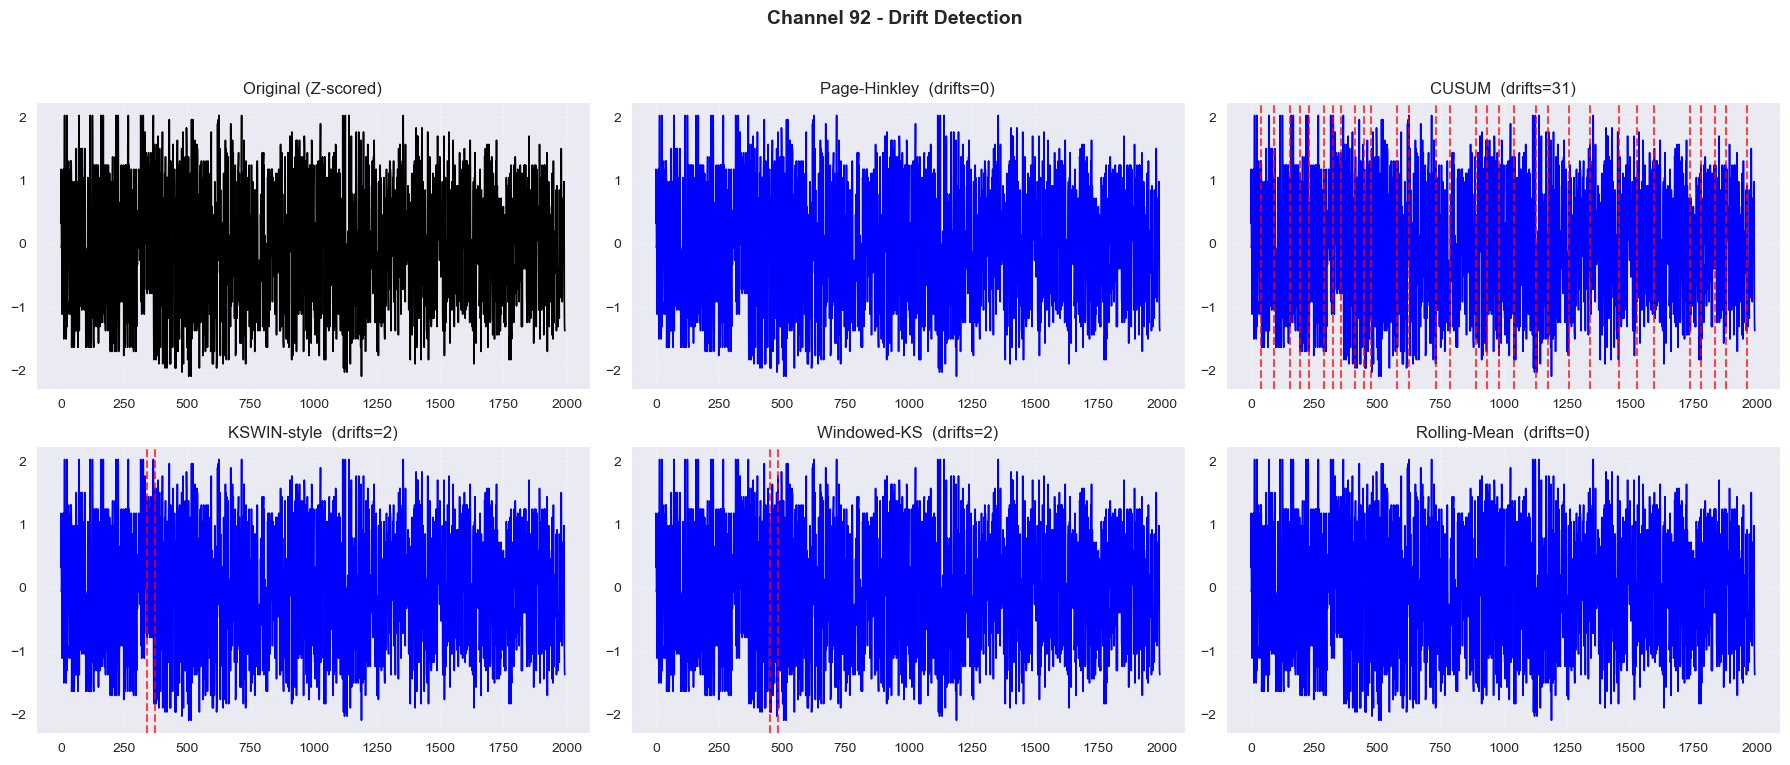

In [9]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import os

# مسیر پوشه‌ی خروجی
central_output_root = r"All_Cleaned_Plots"
os.makedirs(central_output_root, exist_ok=True)
output_dir_central = os.path.join(central_output_root, rel_path, 'plots')

# ===== توابع دریفت =====
def zscore_arr(x):
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x)
    mu = np.median(x)
    sig = np.std(x) + 1e-8
    return (x - mu) / sig

def dedup_by_gap(idxs, min_gap=30):
    idxs = sorted(set(int(i) for i in idxs if i >= 0))
    if not idxs: return []
    keep = [idxs[0]]
    for i in idxs[1:]:
        if i - keep[-1] >= min_gap:
            keep.append(i)
    return keep

def page_hinkley_detect(x, delta=0.01, lambd=50.0, alpha=0.999):
    marks, mean, s, cum_low = [], 0.0, 0.0, 0.0
    for i, xi in enumerate(x, 1):
        mean = xi if i == 1 else alpha * mean + (1 - alpha) * xi
        s += xi - mean - delta
        cum_low = min(cum_low, s)
        if s - cum_low > lambd:
            marks.append(i - 1)
            s, cum_low = 0.0, 0.0
    return marks

def cusum_detect(x, threshold=8.0, drift=0.02):
    pos = neg = 0.0
    marks = []
    for i, xi in enumerate(x):
        pos = max(0.0, pos + xi - drift)
        neg = min(0.0, neg + xi + drift)
        if pos > threshold or -neg > threshold:
            marks.append(i)
            pos = neg = 0.0
    return marks

def ks_two_window_detect(x, w=200, alpha=1e-3):
    marks = []
    for i in range(2 * w, len(x)):
        a = x[i - 2 * w : i - w]
        b = x[i - w : i]
        if len(a) == w and len(b) == w:
            _, p = stats.ks_2samp(a, b)
            if p < alpha:
                marks.append(i)
    return marks

def kswin_style_detect(x, alpha=1e-3, r=50, w=200):
    marks = []
    if w <= r or w > len(x): return marks
    for i in range(w, len(x)):
        ref = x[i - w : i - r]
        test = x[i - r : i]
        if len(ref) == (w - r) and len(test) == r:
            _, p = stats.ks_2samp(ref, test)
            if p < alpha:
                marks.append(i)
    return marks

def rolling_mean_shift_detect(x, win=5, zthr=3.5):
    marks = []
    if 2 * win >= len(x): return marks
    cumsum = np.cumsum(np.insert(x, 0, 0))
    for i in range(win, len(x) - win):
        left_mean = (cumsum[i] - cumsum[i - win]) / win
        right_mean = (cumsum[i + win] - cumsum[i]) / win
        diff = right_mean - left_mean
        s = np.std(x[i - win : i + win]) + 1e-8
        if abs(diff) / s > zthr:
            marks.append(i)
    return marks

def plot_all_detectors(x, detections, save_path, title=""):
    """
    detections = dict(name -> list of indices)
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.ravel()

    # 1️⃣ سیگنال اصلی
    axes[0].plot(x, color="black", lw=1.2)
    axes[0].set_title("Original (Z-scored)")
    axes[0].grid(True, linestyle=':', alpha=0.6)

    # ۲ تا ۶ : الگوریتم‌ها
    for ax, (name, marks) in zip(axes[1:], detections.items()):
        ax.plot(x, color="blue", lw=1.2)
        for m in marks:
            ax.axvline(m, color="red", linestyle="--", alpha=0.7)
        ax.set_title(f"{name}  (drifts={len(marks)})")
        ax.grid(True, linestyle=':', alpha=0.6)

    for ax in axes[len(detections)+1:]:
        ax.axis("off")

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.savefig(save_path, dpi=200)
    plt.close()

# ===== اجرای دریفت برای هر کانال =====
drift_root = os.path.join(output_dir_central, "drift_plots")
os.makedirs(drift_root, exist_ok=True)

for col in range(df_cleaned.shape[1]):
    channel_data = df_cleaned[col].dropna().values
    if len(channel_data) < 50:
        continue

    x_z = zscore_arr(channel_data)

    detections = {
        "Page-Hinkley": dedup_by_gap(page_hinkley_detect(x_z)),
        "CUSUM":        dedup_by_gap(cusum_detect(x_z)),
        "KSWIN-style":  dedup_by_gap(kswin_style_detect(x_z)),
        "Windowed-KS":  dedup_by_gap(ks_two_window_detect(x_z)),
        "Rolling-Mean": dedup_by_gap(rolling_mean_shift_detect(x_z))
    }

    save_path = os.path.join(drift_root, f"channel_{col}_all_detectors.png")
    plot_all_detectors(
        x_z, detections,
        save_path,
        title=f"Channel {col} - Drift Detection"
    )


میانگین کل رو گرفتم بعد دریفت زدم
---
---
ئ

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ===== مسیر خروجی جدید =====
alltogather_root = os.path.join(output_dir_central, "alltogather")
os.makedirs(alltogather_root, exist_ok=True)

# ===== توابع (همان قبلی‌ها) =====
def zscore_arr(x):
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x)
    mu = np.median(x)
    sig = np.std(x) + 1e-8
    return (x - mu) / sig

def dedup_by_gap(idxs, min_gap=30):
    idxs = sorted(set(int(i) for i in idxs if i >= 0))
    if not idxs: return []
    keep = [idxs[0]]
    for i in idxs[1:]:
        if i - keep[-1] >= min_gap:
            keep.append(i)
    return keep

def page_hinkley_detect(x, delta=0.01, lambd=50.0, alpha=0.999):
    marks, mean, s, cum_low = [], 0.0, 0.0, 0.0
    for i, xi in enumerate(x, 1):
        mean = xi if i == 1 else alpha * mean + (1 - alpha) * xi
        s += xi - mean - delta
        cum_low = min(cum_low, s)
        if s - cum_low > lambd:
            marks.append(i - 1)
            s, cum_low = 0.0, 0.0
    return marks

def cusum_detect(x, threshold=8.0, drift=0.02):
    pos = neg = 0.0
    marks = []
    for i, xi in enumerate(x):
        pos = max(0.0, pos + xi - drift)
        neg = min(0.0, neg + xi + drift)
        if pos > threshold or -neg > threshold:
            marks.append(i)
            pos = neg = 0.0
    return marks

def ks_two_window_detect(x, w=200, alpha=1e-3):
    marks = []
    for i in range(2 * w, len(x)):
        a = x[i - 2 * w : i - w]
        b = x[i - w : i]
        if len(a) == w and len(b) == w:
            _, p = stats.ks_2samp(a, b)
            if p < alpha:
                marks.append(i)
    return marks

def kswin_style_detect(x, alpha=1e-3, r=50, w=200):
    marks = []
    if w <= r or w > len(x): return marks
    for i in range(w, len(x)):
        ref = x[i - w : i - r]
        test = x[i - r : i]
        if len(ref) == (w - r) and len(test) == r:
            _, p = stats.ks_2samp(ref, test)
            if p < alpha:
                marks.append(i)
    return marks

def rolling_mean_shift_detect(x, win=5, zthr=3.5):
    marks = []
    if 2 * win >= len(x): return marks
    cumsum = np.cumsum(np.insert(x, 0, 0))
    for i in range(win, len(x) - win):
        left_mean = (cumsum[i] - cumsum[i - win]) / win
        right_mean = (cumsum[i + win] - cumsum[i]) / win
        diff = right_mean - left_mean
        s = np.std(x[i - win : i + win]) + 1e-8
        if abs(diff) / s > zthr:
            marks.append(i)
    return marks

def plot_all_detectors(x, detections, save_path, title=""):
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.ravel()

    # 1️⃣ سیگنال اصلی
    axes[0].plot(x, color="black", lw=1.2)
    axes[0].set_title("Original (Z-scored)")
    axes[0].grid(True, linestyle=":", alpha=0.6)

    # ۲ تا ۶: الگوریتم‌ها
    for ax, (name, marks) in zip(axes[1:], detections.items()):
        ax.plot(x, color="blue", lw=1.2)
        for m in marks:
            ax.axvline(m, color="red", linestyle="--", alpha=0.7)
        ax.set_title(f"{name}  (drifts={len(marks)})")
        ax.grid(True, linestyle=":", alpha=0.6)

    for ax in axes[len(detections)+1:]:
        ax.axis("off")

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=200)
    plt.close()

# ===== میانگین همه کانال‌ها =====
mean_signal = df_cleaned.mean(axis=1, skipna=True).values
if len(mean_signal) >= 50:
    x_z = zscore_arr(mean_signal)

    detections = {
        "Page-Hinkley": dedup_by_gap(page_hinkley_detect(x_z)),
        "CUSUM":        dedup_by_gap(cusum_detect(x_z)),
        "KSWIN-style":  dedup_by_gap(kswin_style_detect(x_z)),
        "Windowed-KS":  dedup_by_gap(ks_two_window_detect(x_z)),
        "Rolling-Mean": dedup_by_gap(rolling_mean_shift_detect(x_z))
    }

    save_path = os.path.join(alltogather_root, "alltogather_drift.png")
    plot_all_detectors(
        x_z,
        detections,
        save_path,
        title="All Channels Together - Drift Detection"
    )
else:
    print("Signal too short for drift detection.")


انال های که توزیع گوشی نداشتن روحذف کردم بعد میانگین گرفتم بعد تشخیص دریفت دادم
---
---

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ===== مسیر خروجی جدید =====
alltogather_root = os.path.join(output_dir_central, "alltogather")
os.makedirs(alltogather_root, exist_ok=True)

# ===== توابع =====
def zscore_arr(x):
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x)
    mu = np.median(x)
    sig = np.std(x) + 1e-8
    return (x - mu) / sig

def dedup_by_gap(idxs, min_gap=30):
    idxs = sorted(set(int(i) for i in idxs if i >= 0))
    if not idxs: return []
    keep = [idxs[0]]
    for i in idxs[1:]:
        if i - keep[-1] >= min_gap:
            keep.append(i)
    return keep

def page_hinkley_detect(x, delta=0.01, lambd=50.0, alpha=0.999):
    marks, mean, s, cum_low = [], 0.0, 0.0, 0.0
    for i, xi in enumerate(x, 1):
        mean = xi if i == 1 else alpha * mean + (1 - alpha) * xi
        s += xi - mean - delta
        cum_low = min(cum_low, s)
        if s - cum_low > lambd:
            marks.append(i - 1)
            s, cum_low = 0.0, 0.0
    return marks

def cusum_detect(x, threshold=8.0, drift=0.02):
    pos = neg = 0.0
    marks = []
    for i, xi in enumerate(x):
        pos = max(0.0, pos + xi - drift)
        neg = min(0.0, neg + xi + drift)
        if pos > threshold or -neg > threshold:
            marks.append(i)
            pos = neg = 0.0
    return marks

def ks_two_window_detect(x, w=200, alpha=1e-3):
    marks = []
    for i in range(2 * w, len(x)):
        a = x[i - 2 * w : i - w]
        b = x[i - w : i]
        if len(a) == w and len(b) == w:
            _, p = stats.ks_2samp(a, b)
            if p < alpha:
                marks.append(i)
    return marks

def kswin_style_detect(x, alpha=1e-3, r=50, w=200):
    marks = []
    if w <= r or w > len(x): return marks
    for i in range(w, len(x)):
        ref = x[i - w : i - r]
        test = x[i - r : i]
        if len(ref) == (w - r) and len(test) == r:
            _, p = stats.ks_2samp(ref, test)
            if p < alpha:
                marks.append(i)
    return marks

def rolling_mean_shift_detect(x, win=5, zthr=3.5):
    marks = []
    if 2 * win >= len(x): return marks
    cumsum = np.cumsum(np.insert(x, 0, 0))
    for i in range(win, len(x) - win):
        left_mean = (cumsum[i] - cumsum[i - win]) / win
        right_mean = (cumsum[i + win] - cumsum[i]) / win
        diff = right_mean - left_mean
        s = np.std(x[i - win : i + win]) + 1e-8
        if abs(diff) / s > zthr:
            marks.append(i)
    return marks

def plot_all_detectors(x, detections, save_path, title=""):
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.ravel()

    # 1️⃣ سیگنال اصلی
    axes[0].plot(x, color="black", lw=1.2)
    axes[0].set_title("Original (Z-scored)")
    axes[0].grid(True, linestyle=":", alpha=0.6)

    # ۲ تا ۶: الگوریتم‌ها
    for ax, (name, marks) in zip(axes[1:], detections.items()):
        ax.plot(x, color="blue", lw=1.2)
        for m in marks:
            ax.axvline(m, color="red", linestyle="--", alpha=0.7)
        ax.set_title(f"{name}  (drifts={len(marks)})")
        ax.grid(True, linestyle=":", alpha=0.6)

    for ax in axes[len(detections)+1:]:
        ax.axis("off")

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=200)
    plt.close()

# ===== حلقه‌ی افزایش آستانه =====
threshold_list = [10,20,30,40,50,60,70,80,90,100,110,120,200,300]  # می‌توانید مقادیر دلخواه اضافه/حذف کنید

for mean_tol in threshold_list:
    print(f"\n=== Threshold: {mean_tol} ===")

    # 1️⃣ انتخاب کانال‌ها برای این آستانه
    gauss_channels = []
    for col in df_cleaned.columns:
        vals = df_cleaned[col].dropna().values
        if len(vals) < 50:
            continue
        _, p = stats.shapiro(vals)
        if p > 0.05 and abs(np.mean(vals)) < mean_tol:
            gauss_channels.append(col)

    print(f"Channels kept: {gauss_channels}")

    if len(gauss_channels) == 0:
        print("No channels meet this threshold.")
        continue

    # 2️⃣ محاسبه‌ی میانگین و رسم
    mean_signal = df_cleaned[gauss_channels].mean(axis=1, skipna=True).values
    if len(mean_signal) >= 50:
        x_z = zscore_arr(mean_signal)

        detections = {
            "Page-Hinkley": dedup_by_gap(page_hinkley_detect(x_z)),
            "CUSUM":        dedup_by_gap(cusum_detect(x_z)),
            "KSWIN-style":  dedup_by_gap(kswin_style_detect(x_z)),
            "Windowed-KS":  dedup_by_gap(ks_two_window_detect(x_z)),
            "Rolling-Mean": dedup_by_gap(rolling_mean_shift_detect(x_z))
        }

        fname = f"alltogather_drift_meanTol{mean_tol}.png"
        save_path = os.path.join(alltogather_root, fname)
        plot_all_detectors(
            x_z,
            detections,
            save_path,
            title=f"All Channels Together - meanTol={mean_tol}"
        )
    else:
        print("Mean signal too short.")



=== Threshold: 10 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 20 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 30 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 40 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 50 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 60 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 70 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 80 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 90 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 100 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 110 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 120 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 200 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



=== Threshold: 300 ===
Channels kept: [67]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ===== مسیر خروجی =====
alltogather_root = os.path.join(output_dir_central, "alltogather")
os.makedirs(alltogather_root, exist_ok=True)

# ===== توابع =====
def remove_outliers(x, zthr=3.5):
    """حذف مقادیر با |Z| > zthr و جایگزینی با NaN"""
    x = np.asarray(x, dtype=float)
    m = np.nanmean(x)
    s = np.nanstd(x) + 1e-8
    z = (x - m) / s
    x[np.abs(z) > zthr] = np.nan
    return x

def zscore_arr(x):
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x, nan=np.nanmean(x))
    m = np.nanmedian(x)
    s = np.nanstd(x) + 1e-8
    return (x - m) / s

def dedup_by_gap(idxs, min_gap=30):
    idxs = sorted(set(int(i) for i in idxs if i >= 0))
    if not idxs: return []
    keep = [idxs[0]]
    for i in idxs[1:]:
        if i - keep[-1] >= min_gap:
            keep.append(i)
    return keep

def page_hinkley_detect(x, delta=0.01, lambd=50.0, alpha=0.999):
    marks, mean, s, cum_low = [], 0.0, 0.0, 0.0
    for i, xi in enumerate(x, 1):
        mean = xi if i == 1 else alpha * mean + (1 - alpha) * xi
        s += xi - mean - delta
        cum_low = min(cum_low, s)
        if s - cum_low > lambd:
            marks.append(i - 1)
            s, cum_low = 0.0, 0.0
    return marks

def cusum_detect(x, threshold=8.0, drift=0.02):
    pos = neg = 0.0
    marks = []
    for i, xi in enumerate(x):
        pos = max(0.0, pos + xi - drift)
        neg = min(0.0, neg + xi + drift)
        if pos > threshold or -neg > threshold:
            marks.append(i)
            pos = neg = 0.0
    return marks

def ks_two_window_detect(x, w=200, alpha=1e-3):
    marks = []
    for i in range(2 * w, len(x)):
        a = x[i - 2 * w : i - w]
        b = x[i - w : i]
        if len(a) == w and len(b) == w:
            _, p = stats.ks_2samp(a, b)
            if p < alpha:
                marks.append(i)
    return marks

def kswin_style_detect(x, alpha=1e-3, r=50, w=200):
    marks = []
    if w <= r or w > len(x): return marks
    for i in range(w, len(x)):
        ref = x[i - w : i - r]
        test = x[i - r : i]
        if len(ref) == (w - r) and len(test) == r:
            _, p = stats.ks_2samp(ref, test)
            if p < alpha:
                marks.append(i)
    return marks

def rolling_mean_shift_detect(x, win=5, zthr=3.5):
    marks = []
    if 2 * win >= len(x): return marks
    cumsum = np.cumsum(np.insert(x, 0, 0))
    for i in range(win, len(x) - win):
        left_mean = (cumsum[i] - cumsum[i - win]) / win
        right_mean = (cumsum[i + win] - cumsum[i]) / win
        diff = right_mean - left_mean
        s = np.nanstd(x[i - win : i + win]) + 1e-8
        if abs(diff) / s > zthr:
            marks.append(i)
    return marks

def plot_all_detectors(x, detections, save_path, title=""):
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.ravel()
    axes[0].plot(x, color="black", lw=1.2)
    axes[0].set_title("Original (Z-scored)")
    axes[0].grid(True, linestyle=":", alpha=0.6)
    for ax, (name, marks) in zip(axes[1:], detections.items()):
        ax.plot(x, color="blue", lw=1.2)
        for m in marks:
            ax.axvline(m, color="red", linestyle="--", alpha=0.7)
        ax.set_title(f"{name}  (drifts={len(marks)})")
        ax.grid(True, linestyle=":", alpha=0.6)
    for ax in axes[len(detections)+1:]:
        ax.axis("off")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=200)
    plt.close()

def detect_and_plot(signal, save_path, title):
    x = remove_outliers(signal)
    x_z = zscore_arr(x)
    detections = {
        "Page-Hinkley": dedup_by_gap(page_hinkley_detect(x_z)),
        "CUSUM":        dedup_by_gap(cusum_detect(x_z)),
        "KSWIN-style":  dedup_by_gap(kswin_style_detect(x_z)),
        "Windowed-KS":  dedup_by_gap(ks_two_window_detect(x_z)),
        "Rolling-Mean": dedup_by_gap(rolling_mean_shift_detect(x_z))
    }
    plot_all_detectors(x_z, detections, save_path, title)

# ===== میانگین کل کانال‌ها (بدون حذف) =====
all_signal = df_cleaned.mean(axis=1, skipna=True).values
detect_and_plot(
    all_signal,
    os.path.join(alltogather_root, "alltogather_ALLchannels.png"),
    "Mean of ALL Channels (No filtering)"
)

# ===== میانگین کانال‌های فرد و زوج =====
odd_cols  = [c for i,c in enumerate(df_cleaned.columns) if i % 2 == 1]
even_cols = [c for i,c in enumerate(df_cleaned.columns) if i % 2 == 0]

if odd_cols:
    detect_and_plot(
        df_cleaned[odd_cols].mean(axis=1, skipna=True).values,
        os.path.join(alltogather_root, "alltogather_ODDchannels.png"),
        "Mean of ODD Channels (No filtering)"
    )
if even_cols:
    detect_and_plot(
        df_cleaned[even_cols].mean(axis=1, skipna=True).values,
        os.path.join(alltogather_root, "alltogather_EVENchannels.png"),
        "Mean of EVEN Channels (No filtering)"
    )

# ===== حلقه آستانه‌ها =====
mean_tol_list = [0.01,0.02,0.05,0.1,0.2,0.3,0.5,1,5,10,50,100]
for mean_tol in mean_tol_list:
    keep_cols = []
    for col in df_cleaned.columns:
        vals = df_cleaned[col].dropna().values
        if len(vals) < 50: continue
        if abs(np.mean(vals)) < mean_tol:
            keep_cols.append(col)

    print(f"mean_tol={mean_tol} -> kept {len(keep_cols)} channels")
    if not keep_cols: continue

    signal = df_cleaned[keep_cols].mean(axis=1, skipna=True).values
    detect_and_plot(
        signal,
        os.path.join(alltogather_root, f"alltogather_meanTol{mean_tol}.png"),
        f"Filtered Channels – meanTol={mean_tol}"
    )


mean_tol=0.01 -> kept 13 channels
mean_tol=0.02 -> kept 16 channels
mean_tol=0.05 -> kept 23 channels
mean_tol=0.1 -> kept 41 channels
mean_tol=0.2 -> kept 60 channels
mean_tol=0.3 -> kept 72 channels
mean_tol=0.5 -> kept 97 channels
mean_tol=1 -> kept 125 channels
mean_tol=5 -> kept 126 channels
mean_tol=10 -> kept 126 channels
mean_tol=50 -> kept 126 channels
mean_tol=100 -> kept 128 channels
